# packages and imports

In [2]:
import jax.numpy as jnp
import numpy as np
import jax
import optax
from jaxopt import LBFGS
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import equinox as eqx
import scipy.linalg
from jax.nn.initializers import he_normal
from tqdm import tqdm
#import ipympl
from matplotlib import cbook, cm
from matplotlib.colors import LightSource

seed = 42
np.random.seed(seed)
key = jax.random.key(seed)
num_bases = 10
num_trunk_epochs = 10000
lr = 1e-3
num_LBFGS_epochs = 10000

print("\nconfiguring backend...")
jax.config.update("jax_platform_name", "metal")


print("backend selected:\n", jax.default_backend())
print("active devices:\n", jax.devices())
print("--------------------\n")

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB


configuring backend...
backend selected:
 METAL
active devices:
 [METAL(id=0)]
--------------------



W0000 00:00:1762635419.259187 9161257 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1762635419.286833 9161257 service.cc:145] XLA service 0x307b96100 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762635419.286860 9161257 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1762635419.288568 9161257 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1762635419.288578 9161257 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.


In [3]:
## EQUINOX CLASS DEFINITIONS
# Linear Model (Wx + b)
class Linear(eqx.Module):
    weight: jax.Array
    bias: jax.Array

    def __init__(self, in_size, out_size, key, initializer = he_normal()):
        wkey, bkey = jax.random.split(key)
        self.weight = initializer(wkey, (out_size, in_size), dtype=jnp.float32)
        self.bias = jnp.zeros((out_size,), dtype=jnp.float32)

    def __call__(self, x):
        return self.weight @ x + self.bias


# Basic MultiLayer Perceptron Primitive
class MLP(eqx.Module):
    layers: list
    activations: list

    def __init__(self, architecture, key, activation = jax.nn.relu, initializer = he_normal()):
        """
        architecture: List[in, hidden1, hidden2, ..., out]
        key: random key
        activation: jax.nn act fxn
        """
        keys = jax.random.split(key, len(architecture) - 1)
        self.layers = [
            Linear(architecture[i], architecture[i+1], keys[i], initializer = initializer) for i in range(len(architecture) - 1)]
        self.activations = [activation] * (len(self.layers) - 1) + [eqx.nn.Identity()] # no activation on last layer

    def __call__(self, x):
        for layer, act in zip(self.layers, self.activations):
            x = act(layer(x))
        return x

# WITH TIME STRIDE

## loading dataset

In [20]:
# load external dataset
# NOTE we're loading t, and subsampling every 2 steps

TIME_STRIDE = 30

dataset = np.load('/Users/haydenoutlaw/Documents/Research/opnet/deep-operator-networks/data/burgers_dataset.npz', allow_pickle = True)
t_grid_full = jnp.array(dataset['t'])
t_grid = t_grid_full[::TIME_STRIDE] #subsampling t every 2 steps
x_grid = jnp.array(dataset['x'])
print("grid is (t,x) = ", len(t_grid), len(x_grid))

data = dataset['samples']
u = np.array([i['params'] for i in data])
s = np.array([i['solution'] for i in data]) # s is shape (n, t, x)

# disabled functionality for train/test split for now
#n_samp = len(data)
#train_indices, test_indices = train_test_split(np.arange(n_samp), test_size = 0.0, random_state = seed)
#u_train, u_test = jnp.array(u[train_indices]), jnp.array(u[test_indices])
#s_train, s_test = jnp.array(s[train_indices]), jnp.array(s[test_indices])

u_train, s_train = u,s
print('dataset size is (n, coord) = ', u_train.shape)

grid is (t,x) =  7 201
dataset size is (n, coord) =  (441, 2)


## generating data objects

In [ ]:
# flatten into list of coordinates (x,t)
xx, tt = jnp.meshgrid(x_grid,t_grid)
xt_grid = jnp.concatenate([xx.flatten()[:,None], tt.flatten()[:,None]], axis=1) #xt_grid[:,0] is x, xt_grid[:,1] is t
print("xt_grid is of shape (n, coord) = ",xt_grid.shape)

output_tr = jnp.transpose(s_train[:,:,::TIME_STRIDE], axes=(2,1,0)) # (n,x,t) -> (t,x,n). subselecting every few indices of t! 
print("formatted training data output_tr is of shape (t,x,n) = ", output_tr.shape)

xt_grid is of shape (n, coord) =  (1407, 2)
formatted training data output_tr is of shape (t,x,n) =  (7, 201, 441)


## initializing model, loss_fn

In [6]:
u_dim = 2 # in this case, two 
y_dim = 2 # (t,x)
# define architectures for component networks
branch_arch = [u_dim, 40, 40, num_bases] 
trunk_arch  = [y_dim, 40, 40, num_bases] 

key, subkey_t, subkey_A = jax.random.split(key, num=3)
trunk_model = MLP(trunk_arch,key = subkey_t)
A_model = jax.random.normal(subkey_A, (len(t_grid), num_bases, s_train.shape[0])) # now A_model is a 3-tensor -- indexed as t, branch, n. as opposed to one matrix for entire xt domain
print("A_model is shape:", A_model.shape)

model = trunk_model, A_model

def loss_fn(model):
    trunk_model, A_model = model
    T_MAT = jax.vmap(lambda t: jax.vmap(lambda x: trunk_model(jnp.stack([x,t])))(x_grid))(t_grid) # trunk model matrix. output of model given input entire [x_grid, t_grid]
    pred_y = jnp.einsum("txN, tNk -> txk",T_MAT, A_model) # einsum is a tensor contraction. keep t index (time) and at each t index, do (x,N) times (N,k) -> (x,k). N = num_fxns, k = num_samples
    # pred_y[i,:,:] = T_mat[i,:,:] @ A_model[i,:,:], T_mat @ A_model for each individual time, analogous to vanilla case
    return jnp.mean((output_tr - pred_y) ** 2) # mean squared error, absolute

A_model is shape: (7, 10, 441)


In [7]:
opt = optax.adam(lr)
opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

adam_epochs = 12000


loss_hist = []
# standard eqx training step
@eqx.filter_jit
def train_step(model, opt_state):
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model)
    updates, opt_state = opt.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

for step in range(adam_epochs):
    model, opt_state, loss = train_step(model, opt_state)
    loss_hist.append(float(loss)) # store as list
    if step % 100 == 0: # new carriage print, avoid tqdm for memory
        print(f"\rAdam step {step}: loss={float(loss):.3e}", end="", flush=True)

print("\nfinal adam loss:", loss)


## LBFGS disabled for now. rebuild to match adam
# opt = optax.lbfgs()

# for step in range(num_LBFGS_epochs):
#     model, opt_state, loss = train_step(model, opt_state, (xt_grid, ss_grid))
#     loss_hist.append(float(loss))
#     if step % 1000 == 0:
#         print(f"LBFGS step {step}: loss={float(loss):.3e}")


Adam step 11900: loss=5.345e-05
final adam loss: 6.157528e-05


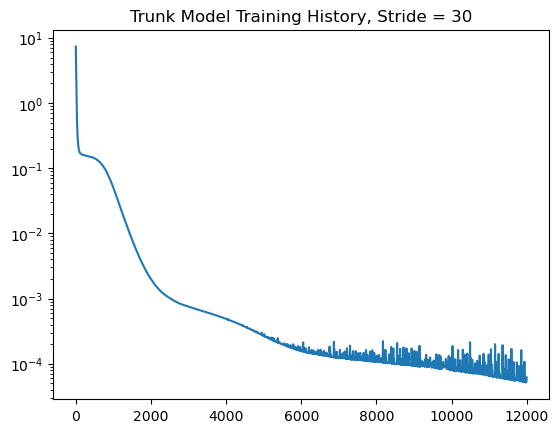

In [8]:
plt.plot(loss_hist)
plt.title(f"Trunk Model Training History, Stride = {TIME_STRIDE}")
plt.yscale('log')

## QR Factorizations at Time Data

In [9]:
# SAME LOGIC AS ABOVE - T_MAT is trunk matrixm output of entire [x_grid, t_grid]
T_MAT = jax.vmap(lambda t: jax.vmap(lambda x: trunk_model(jnp.stack([x,t])))(x_grid))(t_grid)
print("T_MAT is shape (t,x,n) = ", T_MAT.shape)
# Q_MAT = []

# for index i of t_grid (subsampled here every 2)
for i in range(len(t_grid)):
    # take QR of T_MAT[i,:,:]
    Q,R = scipy.linalg.qr(T_MAT[i], mode = 'economic')
    if i == 0:
        Q_MAT = Q[jnp.newaxis,:,:] # make the 3 tensor
    else:
        Q_MAT = jnp.concatenate([Q_MAT, Q[jnp.newaxis,:,:]], axis=0) # stack Q_MAT in first dimension
    
print("Q_MAT is of shape (t,x,n) = ", Q_MAT.shape)
print("shapes agree?", Q_MAT.shape == T_MAT.shape)

T_MAT is shape (t,x,n) =  (7, 201, 10)
Q_MAT is of shape (t,x,n) =  (7, 201, 10)
shapes agree? True


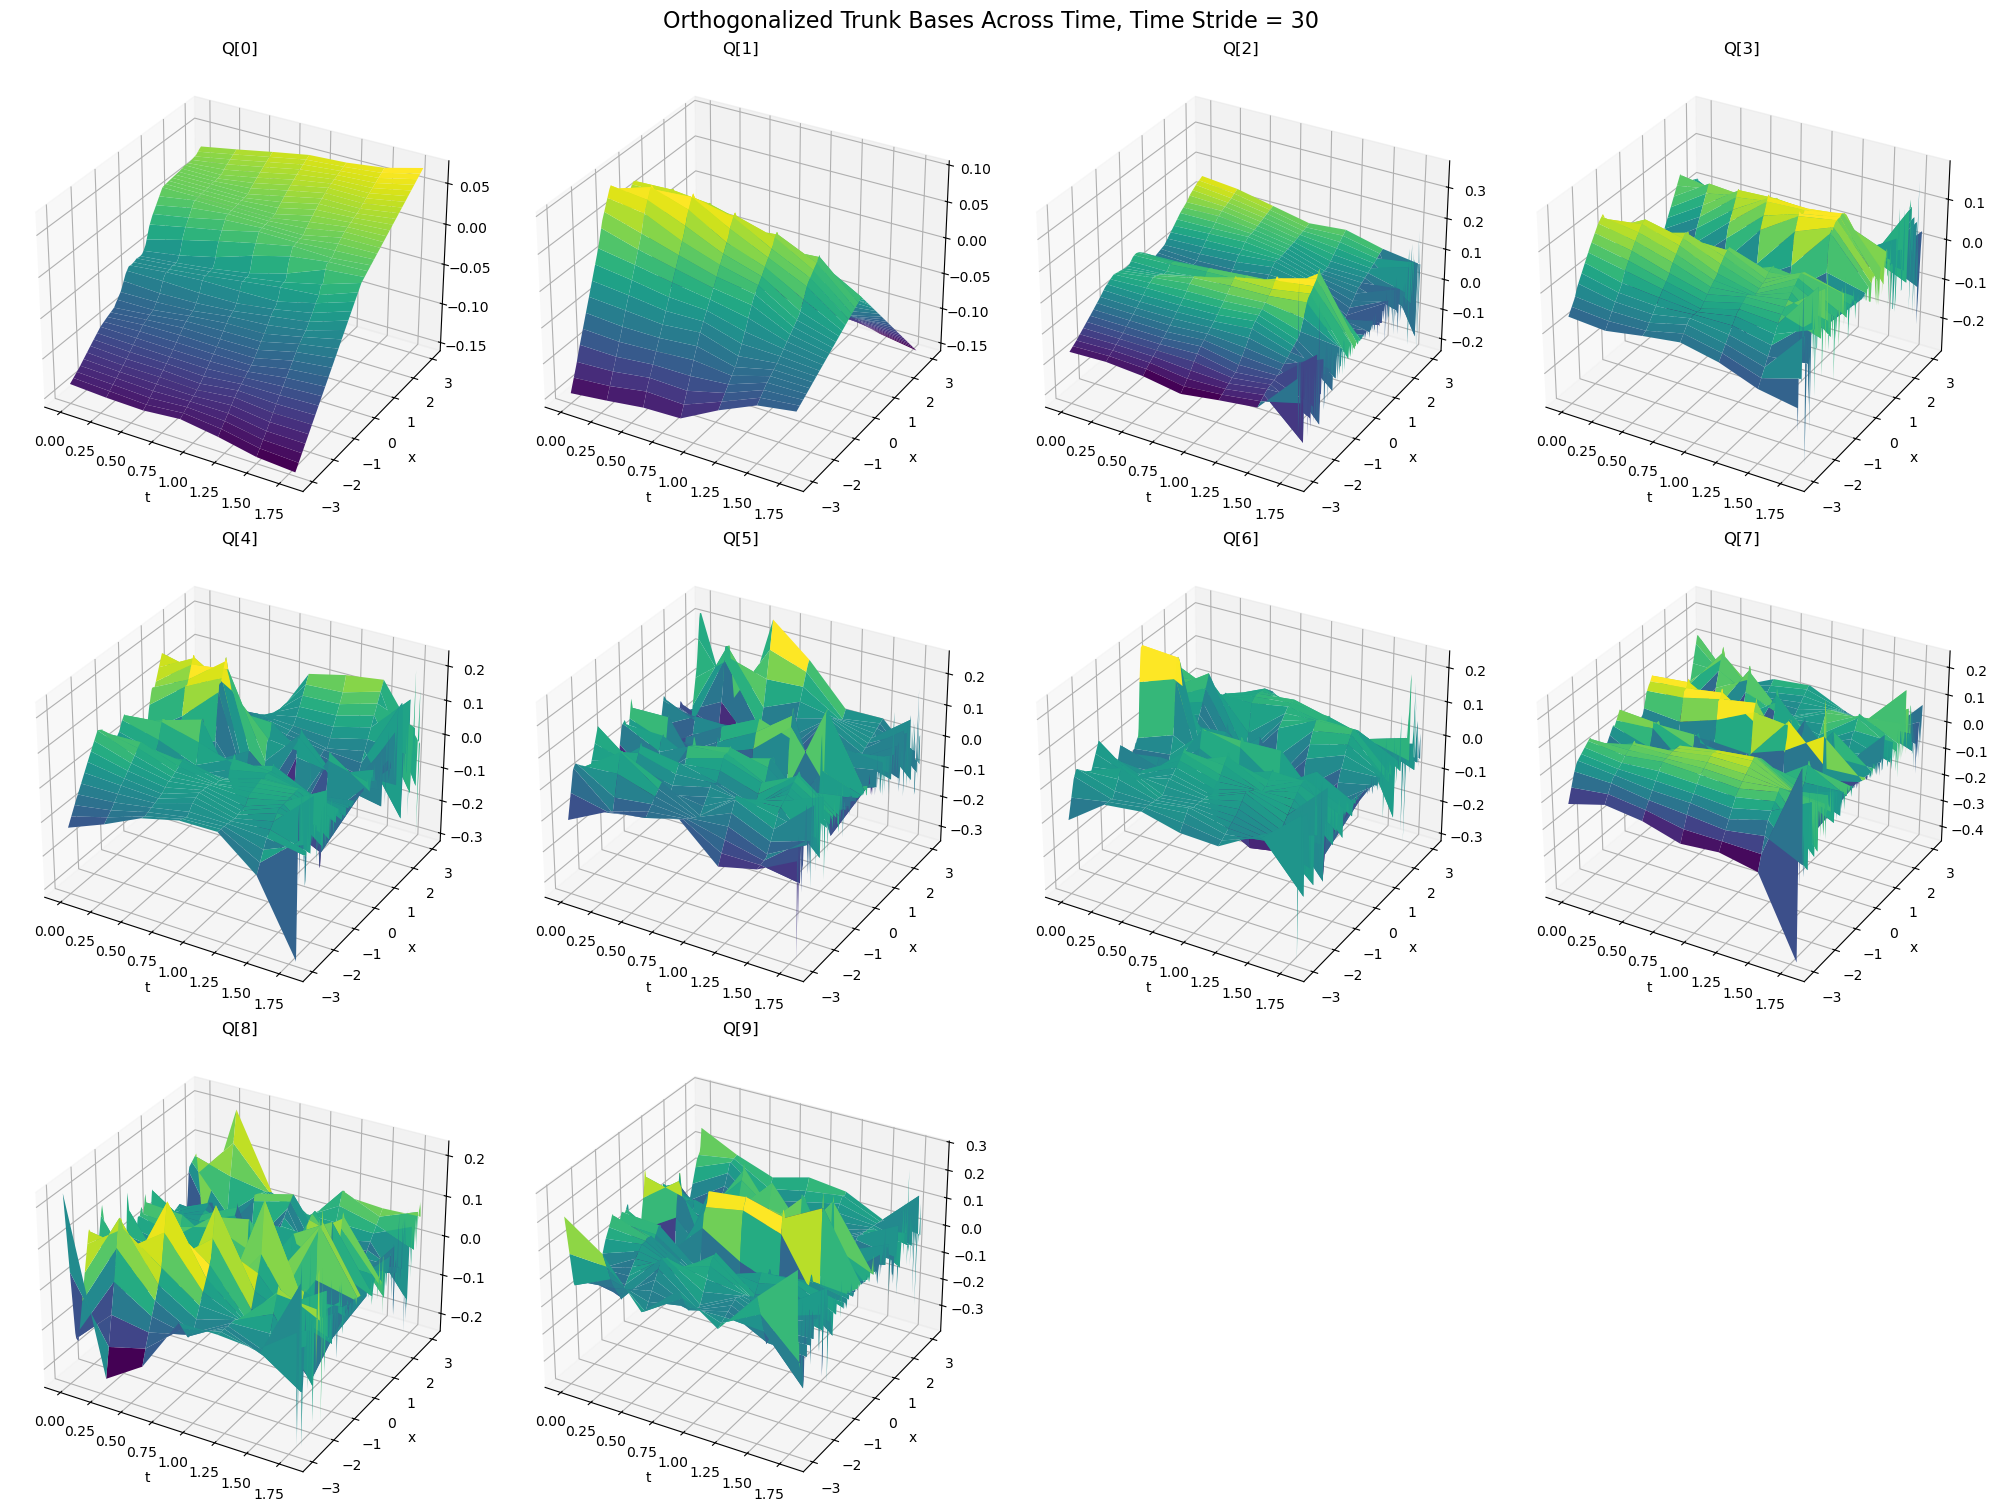

In [ ]:
ncols = 4
nrows = int(np.ceil(num_bases / ncols))
T, X = np.meshgrid(t_grid, x_grid, indexing="ij") 

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows), constrained_layout=True, subplot_kw = dict(projection = '3d'))

# flatten axes array for easy indexing
axes = axes.flatten()

for k, ax in enumerate(axes):
    if k < num_bases:
        Q_k = Q_MAT[:,:,k]
        im = ax.plot_surface(T,X,Q_k, cmap = 'viridis')
        ax.set_title(f"Q[{k}]")
        ax.set_xlabel("t")
        ax.set_ylabel("x")
    else:
        ax.axis("off")

fig.suptitle(f"Orthogonalized Trunk Bases Across Time, Time Stride = {TIME_STRIDE}", fontsize=16)
plt.show()


In [11]:
t_grid

Array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8], dtype=float32)

In [ ]:
# SAME LOGIC AS ABOVE - T_MAT is trunk matrixm output of entire [x_grid, t_grid]
T_MAT = jax.vmap(lambda t: jax.vmap(lambda x: trunk_model(jnp.stack([x,t])))(x_grid))(t_grid)
print("T_MAT is shape (t,x,n) = ", T_MAT.shape)
# Q_MAT = []

# for index i of t_grid (subsampled here every 2)
for i in range(len(t_grid)):
    # take QR of T_MAT[i,:,:]
    Q,R = scipy.linalg.qr(T_MAT[i], mode = 'economic')
    if i == 0:
        Q_MAT = Q[jnp.newaxis,:,:] # make the 3 tensor
        R_MAT = R[jnp.newaxis,:,:]
    else:
        Q_MAT = jnp.concatenate([Q_MAT, Q[jnp.newaxis,:,:]], axis=0) # stack Q_MAT in first dimension
        R_MAT = jnp.concatenate([R_MAT, R[jnp.newaxis, :, :]], axis = 0)
    
print("Q_MAT is of shape (t,x,n) = ", Q_MAT.shape)
print("shapes agree?", Q_MAT.shape == T_MAT.shape)
print("R_MAT is of shape (t, n, n) = ", R_MAT.shape )

T_MAT is shape (t,x,n) =  (7, 201, 10)
Q_MAT is of shape (t,x,n) =  (7, 201, 10)
shapes agree? True
R_MAT is of shape (t, n, n) (7, 10, 10)


In [ ]:
xx, tt = jnp.meshgrid(x_grid,t_grid) # this is the subsampled grid
xt_grid = jnp.concatenate([xx.flatten()[:,None], tt.flatten()[:,None]], axis=1) #xt_grid[:,0] is x, xt_grid[:,1] is t
print("xt_grid is of shape (n, coord) = ",xt_grid.shape)

output_tr_full = jnp.transpose(s_train, axes=(2,1,0)) # (n,x,t) -> (t,x,n). subselecting every few indices of t! 
print("formatted full training data (w/o t stride) output_tr_full is of shape (t,x,n) = ", output_tr_full.shape)

xt_grid is of shape (n, coord) =  (1407, 2)
formatted full training data (w/o t stride) output_tr_full is of shape (t,x,n) =  (201, 201, 441)


In [36]:
t_grid

Array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8], dtype=float32)

In [21]:
t_grid_full

Array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
       1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ,
       1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31,
       1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42,
       1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.

In [46]:
indices = jnp.searchsorted(t_grid, t_grid_full, 'right')
print(indices)

lower = jnp.clip(indices - 1, 0, t_grid.size - 2)
upper = lower + 1
intervals = jnp.stack([lower, upper], axis = 1)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]


In [55]:
branch_output_data = []

for i, t in enumerate(t_grid_full):
    s_train_i = s_train[i]
    t0, t1 = t_grid[intervals[i][0]], t_grid[intervals[i][1]]
    print(t, t_grid[intervals[i]], intervals[i])
    w_0, w_1 = (t - t0)/(t1 - t0), (t1 - t)/(t1 - t0)
    R0, R_1 = R_MAT[intervals[i][0]], R_MAT[intervals[i][1]]
    print(w_0, w_1)
    print()


0.0 [0.  0.3] [0 1]
0.0 1.0

0.01 [0.  0.3] [0 1]
0.03333333 0.9666667

0.02 [0.  0.3] [0 1]
0.06666666 0.9333333

0.03 [0.  0.3] [0 1]
0.099999994 0.9

0.04 [0.  0.3] [0 1]
0.13333333 0.8666667

0.05 [0.  0.3] [0 1]
0.16666666 0.8333333

0.06 [0.  0.3] [0 1]
0.19999999 0.8

0.07 [0.  0.3] [0 1]
0.23333332 0.7666667

0.08 [0.  0.3] [0 1]
0.26666665 0.73333335

0.09 [0.  0.3] [0 1]
0.3 0.7

0.1 [0.  0.3] [0 1]
0.3333333 0.6666667

0.11 [0.  0.3] [0 1]
0.36666664 0.6333333

0.12 [0.  0.3] [0 1]
0.39999998 0.6

0.13 [0.  0.3] [0 1]
0.4333333 0.5666667

0.14 [0.  0.3] [0 1]
0.46666664 0.53333336

0.15 [0.  0.3] [0 1]
0.5 0.5

0.16 [0.  0.3] [0 1]
0.5333333 0.4666667

0.17 [0.  0.3] [0 1]
0.56666666 0.43333334

0.18 [0.  0.3] [0 1]
0.6 0.4

0.19 [0.  0.3] [0 1]
0.6333333 0.3666667

0.2 [0.  0.3] [0 1]
0.6666666 0.33333334

0.21 [0.  0.3] [0 1]
0.6999999 0.30000004

0.22 [0.  0.3] [0 1]
0.7333333 0.2666667

0.23 [0.  0.3] [0 1]
0.76666665 0.23333335

0.24 [0.  0.3] [0 1]
0.79999995 0.2000000